# Machine Learning in Python - Project 1

#### Contributors - Qinqing Li, Yuli Wahyu, Jack, Matas Bukelskis

## Setup

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.ticker import FuncFormatter

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Lasso, ElasticNetCV, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def model_fit(model, X_test, y_test, plot=False):
    # Calculate MSE
    mse = mean_squared_error(y_test, model.predict(X_test))

    # Calculate RMSE
    rmse = np.sqrt(mse)

    # Calculate R^2
    r2 = r2_score(y_test, model.predict(X_test))

    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R^2):", r2)

    if plot:
        # Calculate residuals
        fresiduals = y_test - model.predict(X_test)

        # Actual vs. Fitted plot
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, model.predict(X_test))
        plt.plot(y_test, y_test, color='red', linestyle='-')  # Add diagonal line at y=x
        plt.xlabel('Actual Values')
        plt.ylabel('Fitted Values')
        plt.title('Actual vs Fitted for Full Values')

        # Fitted vs. Residual plot
        plt.subplot(1, 2, 2)
        plt.scatter(model.predict(X_test), fresiduals)
        plt.axhline(y=0, color='r', linestyle='-')  # Add horizontal line at y=0
        plt.xlabel('Fitted Values')
        plt.ylabel('Residuals')
        plt.title('Fitted vs Residuals for Full Values')

        plt.tight_layout()
        plt.show()

## Introduction

With the increasing standard of living seen all around the world and major strides
taken to address deaths by communicable diseases<sup>[1]</sup>, non-communicable diseases
such as Alzheimer's and Dementia are now at the forefront of public concern. In
the face of rapidly aging societies, these diseases are projected to become a major threat.
The number of people at risk of Dementia is expected to triple by 2050, with the global
burden of this disease exceeding an estimated US$1 trillion annually<sup>[2]</sup>. Thus, action
must be taken to identify modifiable risk factors so that appropriate intervention
can be taken to reduce these numbers.

To this end, the objective of this study is to make use of the Survey of Health, Ageing and Retirement in Europe (SHARE)
dataset<sup>[3]</sup> to identify key socio-economic factors involved in cognitive
ability decline. The SHARE project provides us with extensive data on the lifestyle
and choices of individuals over 50, collected through interviews and surveys carried out in 27 European
countries and Israel. Among this data are recorded previously known risk factors for dementia,
such as education, depression, and alcoholism<sup>[2]</sup>. We will be making use of
a pre-processed version of the easySHARE dataset provided as part of the Machine Learning
in Python course. This dataset contains a more condensed set of features than the full SHARE dataset.
As a proxy for dementia, we will be using a set of cognitive ability tests, combined into
a single cognitive score, hereafter referred to as `cogscore`.

This study will be using statistical regression models to examine relationships
between various modifiable factors described in the easySHARE dataset and `cogscore`,
providing insight into the relative impact of the examined factors on Dementia risk.
We begin by first cleaning the dataset and examining the features contained within.
We then carry out feature engineering to make some features more amenable to interpretation.
Finally, we fit a combination of different regression models to the data, and examine
the performance of our final model and the relative contribution of each of the dementia
risk factors.

## Exploratory Data Analysis and Feature Engineering

To begin with, we examine the features of the easySHARE dataset. For each subject
that participated in the SHARE survey, the dataset contains 23 recorded features
broadly describing 3 areas: (1) temporal and locational information on when
the subject interview was taken, (2) subject personal information collected during interviews,
and (3) cogscore - an engineered measure of cognitive ability derived from
two word recall, two numeracy, and one orientation test taken during subject interviews.
A short description of the features is provided in the `Feature Summary` section below.
Full details describing the meaning of specific variables can be found in the easySHARE
release guide<sup>[3]</sup>.

In [3]:
data = pd.read_csv("easyshare.csv")
print('Features present in the dataset: ' + ', '.join(data.columns.values))
print(f'Total number of features: {len(data.columns)}')
print(f'Total number of observations: {data.shape[0]}')
data.head(5)

Features present in the dataset: mergeid, int_year, wave, country, country_mod, female, age, birth_country, citizenship, isced1997_r, eduyears_mod, eurod, bmi, bmi2, smoking, ever_smoked, br010_mod, br015_, casp, chronic_mod, sp008_, ch001_, cogscore
Total number of features: 23
Total number of observations: 98348


,mergeid,int_year,wave,country,country_mod,female,age,birth_country,citizenship,isced1997_r,...,bmi2,smoking,ever_smoked,br010_mod,br015_,casp,chronic_mod,sp008_,ch001_,cogscore
0,AT-000674-01,2011.0,4.0,11.0,40.0,1.0,59.700001,40.0,40.0,5.0,...,2.0,5.0,5.0,5.0,1.0,44.0,1.0,5.0,2.0,8.0
1,AT-001215-01,2011.0,4.0,11.0,40.0,1.0,72.599998,528.0,528.0,5.0,...,3.0,1.0,1.0,2.0,1.0,35.0,6.0,1.0,0.0,14.5
2,AT-001492-01,2011.0,4.0,11.0,40.0,1.0,59.599998,40.0,40.0,3.0,...,2.0,5.0,1.0,7.0,2.0,43.0,1.0,5.0,6.0,18.5
3,AT-001492-02,2011.0,4.0,11.0,40.0,0.0,59.799999,40.0,40.0,4.0,...,2.0,1.0,1.0,7.0,3.0,47.0,1.0,NaN,6.0,24.0
4,AT-001816-01,2004.0,1.0,11.0,40.0,1.0,61.299999,40.0,40.0,3.0,...,2.0,5.0,1.0,4.0,3.0,43.0,0.0,5.0,2.0,20.0


#### Feature Summary

1. Temporal and locational information

    - `mergeid` - Unique personal identifier

    - `int_year` - Year of interview. From 2004 to 2020

    - `wave` - SHARE wave the interview was a part of. From $1$ to $8$

    - `country` and `country_mod` - Interview locational country identifiers, the latter being ISO-encoded

2. Subject personal information

    - `birth_country` and `citizenship` - Country of birth/citizenship (ISO-encoded)

    - `female` - Gender. 0 for male, 1 for female

    - `age` - Age at interview

     - `isced1997_r` - Level of education:
        - 0 : none
        - 1 : Level 1 – Primary School
        - 2 : Level 2 – Junior High School, GCSE level
        - 3 : Level 3 – High School, A-Level or equivalent
        - 4 : Level 4 – Apprenticeship programmes, Certificate programmes or equivalent
        - 5 : Level 5 – Bachelor's or similar
        - 6 : Level 6 – Postgraduate

    - `eduyears_mod` - Years spent in education

    - `eurod` - EURO-D depression scale, integrating multiple questions about mental health. From 0 “not depressed” to 12 “very depressed”

    - `bmi` - Body mass index 

    - `bmi2` - Body mass index (categorical):
        - 1: <18.5 – underweight
        - 2: 18.5 - 24.9 – normal
        - 3: 25 - 29.9 – overweight
        - 4: 30 and above – obese

    - `smoking` - Whether respondent smokes currently. 1 for yes, 5 for no.

    - `ever_smoked` - Whether respondent has ever smoked daily. 1 for yes, 5 for no.

    - `br010_mod` - Drinking behavior during the last six (wave 1) or three (waves 2-8) months:
        - 1: not at all
        - 2: less than once a month
        - 3: once or twice a month
        - 4: once or twice a week
        - 5: three or four days a week
        - 6: five or six days a week
        - 7: almost every day

    - `br015_` - Frequency of vigorous activities, including sports, heavy housework, or physical labor:
        - 1: more than once a week
        - 2: once a week
        - 3: one to three times a month
        - 4: hardly ever, or never

    - `casp` - CASP-12 quality of life score, based on 12 aspects<sup>[4]</sup>. From 12 to 48

    - `chronic_mod` - Number of chronic diseases identified by a doctor at some point in life. The following diseases are included in the tally:
        - A heart attack
        - High blood pressure or hypertension
        - High blood cholesterol
        - A stroke or cerebral vascular disease
        - Diabetes or high blood sugar
        - Chronic lung disease (...)
        - Cancer or malignant tumor (...)
        - Stomach or duodenal ulcer, peptic ulcer 
        - Parkinson disease
        - Cataracts
        - Hip fracture or femoral fracture

    - `sp008_` - Whether the respondent has ever given help to people outside the household. Includes personal care, financial or legal help. 1 for yes, 5 for no

    - `ch001_` - Number of children still alive

3. `cogscore` - Cognitive ability score, derived from two word recall, two numeracy, and one orientation test. From 0 to 26.

#### Missing value analysis

Fitting regression models to the dataset requires that no missing values are present.
Thus, before carrying out any analysis on the dataset, we examine the data for missing values
to assess whether to drop the associated observations or impute the missing values.
Figure 1 shows the number of associated missing values for each feature in the dataset.
The largest number of missing values (found within >13,000 of 98348 observations)
correspond to the features `br010_mod`, `sp008_`, `casp`, and `eduyears_mod`.
As indicated by the missing value count table below, most other features contain only 976
rows with missing values which were confirmed to contain null values across all of
the features. Thus, we can simply drop these rows by sub-setting the missing values in `mergeid`.

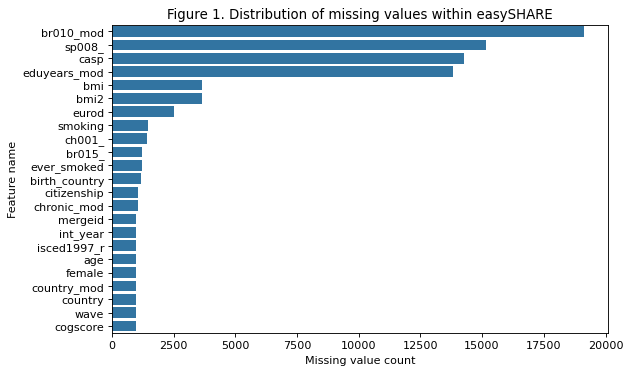

In [4]:
null_vals = data.isnull().sum().rename('null')
null_vals = null_vals.sort_values(ascending=False)
ax = sns.barplot(data=null_vals.reset_index(), x='null', y='index', color='#1f77b4')
ax.set_xlabel('Missing value count')
ax.set_ylabel('Feature name')
ax.set_title('Figure 1. Distribution of missing values within easySHARE')
plt.show()

In [5]:

null_vals1 = data.isnull().sum()

# #drop missing values by mergeid
data = data.dropna(subset=['mergeid'])
print(f'Total number of observations after excluding by `mergeid`: {data.shape[0]}')
null_vals2 = data.isnull().sum()

null_vals_change = pd.DataFrame({'Initial missing values': null_vals1, 'Missing values after excluding by mergeid': null_vals2})
null_vals_change = null_vals_change.sort_values(by='Missing values after excluding by mergeid', ascending=False)
null_vals_change

Total number of observations after excluding by `mergeid`: 97372


,Initial missing values,Missing values after excluding by mergeid
br010_mod,19138,18162
sp008_,15173,14197
casp,14283,13307
eduyears_mod,13816,12840
bmi,3662,2686
bmi2,3662,2686
eurod,2510,1534
smoking,1461,485
ch001_,1420,444
br015_,1235,259


The table displayed below indicates that despite excluding NA observations in mergeid, there are still 14 incomplete features. As a result, we will investigate several features that exhibit correlation with the respon cognitive score in order to ascertain why these observations are missing. The chosen features for in-depth analysis are br010_mod, sp008_, casp, eduyears_mod, eurod, br015_, and chronic_mod, smooking and ever_smoked.

Next, we examine the remaining missing values. In the original SHARE dataset, missing
features are encoded by certain negative values. Thus, by examining the full SHARE dataset
we can get an idea of why these values are missing. A barplot of the number of missing values
for features that exhibit the most correlation with `cogscore` (`br010_mod`, `sp008_`, `casp`, `eduyears_mod`, `eurod`, `br015_`, and `chronic_mod`) is given in Figure 2.
We can see in that for `br010_mod` (drinking behavior) predictive imputation cannot
be employed due to missing values resulting from unasked questions during waves 6 and 8.
Likewise, `casp` (quality of life score) has a significant amount of missing values
only in wave 1, where many respondents did not submit the drop-off questionnaire
that contained questions concerning CASP score.

Most other missing values for `sp008_`, `eduyears_mod`, `eurod`, `br015_` fall under the
general category of "no information", which is described in the easySHARE release guide<sup>[3]</sup> as
missing values that are not explained by filtering or survey design, and thus the
associated features may be used for imputation as they contain no specific wave bias for missing values.

However, aside from `eduyears_mod`, most other features do not have enough correlation with another feature in the dataset to
be used for predictive imputation, and since the easySHARE dataset is already quite large,
we will simply be dropping the rows associated with the missing values to avoid introducing
any potential imputation bias and potentially false conclusions associated with it.
The exception to this is `eduyears_mod`, which has a high relationship with other predictor features.

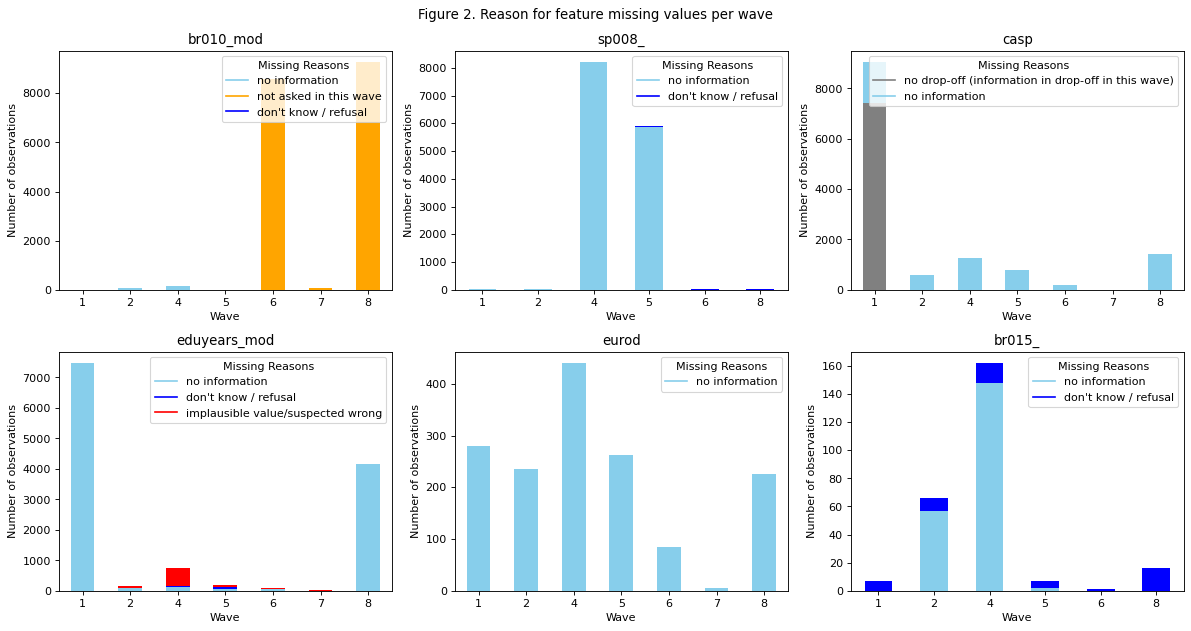

In [6]:
full_data1 = pd.read_csv("easyshare_Features Group 1.csv", sep = ";")
full_data2 = pd.read_csv("easyshare_Features Group 2.csv", sep = ";")
full_data = pd.merge(full_data1, full_data2, on='mergeid', how='inner')

values_to_filter = [-3, -7, -9, -10, -11, -12, -13, -14, -15, -16]
columns_to_filter = ['mergeid', 'wave_x', 'br010_mod', 'sp008_', 'casp', 'eduyears_mod', 'eurod', 'br015_']

# Create a new DataFrame containing only specified columns
dg_filtered = full_data[columns_to_filter]

mis = {}
# Filter rows with specific values in specified columns
for col in columns_to_filter[2:]:  # Skip the first two columns (mergeid and wave)
    mis[col] = dg_filtered[dg_filtered[col].isin(values_to_filter)]

# Create a dictionary mapping values to labels
missing_labels = {
    -3: "implausible value/suspected wrong", -7: "not yet coded", -9: "not applicable filtered",
    -10: "SHARELIFE interview (only in wave 7)", -11: "regular interview (only in wave 7)",
    -12: "don't know / refusal", -13: "not asked in this wave", -14: "not asked in this country",
    -15: "no information", -16: "no drop-off (information in drop-off in this wave)"
}

# Define common color mapping
colors = {
    "implausible value/suspected wrong": 'red',
    "not yet coded": 'purple',
    "not applicable filtered": 'brown',
    "SHARELIFE interview (only in wave 7)": 'yellow',
    "regular interview (only in wave 7)": 'cyan',
    "don't know / refusal": 'blue',
    "not asked in this wave": 'orange',
    "not asked in this country": 'green',
    "no information": 'skyblue',
    "no drop-off (information in drop-off in this wave)": 'gray'
}
# Create subplots with 2 columns and variable rows based on the length of mis
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 4 * num_rows))

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Iterate over each column and create a stacked bar chart
for i, (col, df) in enumerate(mis.items()):
    wave_counts = df.groupby(['wave_x', col]).size().unstack().fillna(0)
    
    # Plot data for each column
    plot_colors = [colors[missing_labels[label]] for label in wave_counts.columns]
    wave_counts.plot(kind='bar', stacked=True, color=plot_colors, ax=axes[i])

    # Create a custom legend
    legend_labels = [plt.Line2D([0], [0], color=colors[missing_labels[label]], label=missing_labels[label]) for label in wave_counts.columns]
    axes[i].legend(handles=legend_labels, title="Missing Reasons", loc='upper right')
    axes[i].set_xticklabels(wave_counts.index, rotation=0)
    axes[i].set_title(col)
    axes[i].set_xlabel('Wave')
    axes[i].set_ylabel('Number of observations')

plt.suptitle('Figure 2. Reason for feature missing values per wave')
plt.tight_layout()
plt.show()

#### Predictive Imputation of `eduyears_mod`

As `eduyears_mod` has a high correlation with `isced1997_r` (level of education) at 0.711,
as well as reasonable negative correlation with `age`at (-0.223),
we use predictive imputation for `eduyears_mod`from those 2 features via stochastic
regression model to estimate missing values. Based on the R^2 value,
it can be observed that 51.2% of the variation in the `eduyears_mod` variable can
be explained by the `isced1997_r` and `age` features alone.
Additionally, the model has a relatively low MSE value of 8.88, indicating that
it can accurately predict values. Therefore, we can rely on this model for predictive
imputation of missing values in the `eduyears_mod` variable.
After inputting the prediction value for the incomplete data from the model above,
`eduyears_mod` no longer has any missing values.

In [7]:
#Observing possible high correlation between eduyear_mod and another predictor features
complete_eduyears = data.dropna(subset=['eduyears_mod']) # Drop rows with missing values in eduyear_mod

corr_isced1997_r = round(complete_eduyears['isced1997_r'].corr(complete_eduyears['eduyears_mod']),3) # Calculate correlation
corr_age = round(complete_eduyears['age'].corr(complete_eduyears['eduyears_mod']),3)

print(f"Correlation between eduyears_mod and isced1997_r: {corr_isced1997_r}")
print(f"Correlation between eduyears_mod and age : {corr_age}")

Correlation between eduyears_mod and isced1997_r: 0.711
Correlation between eduyears_mod and age : -0.223


In [8]:
# Separate the data into two sets: one with missing values in eduyears_mod and one without
missing_values = data[data['eduyears_mod'].isnull()]

# Define y as respon variable and X as predictor variables
y = complete_eduyears['eduyears_mod']
X = complete_eduyears[['isced1997_r', 'age']] 

# Define a pipeline with linear regression
pipeline = Pipeline([
    ('regressor', LinearRegression())  # Linear regression model
])

# Fit the pipeline on the complete dataset
pipeline.fit(X, y)

# Calculate Mean Squared Error (MSE) on the complete dataset
mse = round(mean_squared_error(y, pipeline.predict(X)),3)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate and print the R-squared
r_squared = round(pipeline.score(X, y),3)
print(f'R^2: {r_squared}')

# Print the coefficients and intercept
print(f'Intercept: {pipeline.named_steps["regressor"].intercept_}')
print(f'Coefficients: {pipeline.named_steps["regressor"].coef_}')

Mean Squared Error (MSE): 8.881
R^2: 0.512
Intercept: 7.594737602856318
Coefficients: [ 1.98980485 -0.03696485]


In [9]:
# Predict missing values based on the regression model
missing_values['eduyears_mod_predicted'] = pipeline.predict(missing_values[['isced1997_r', 'age']])

# Round the predicted values to the nearest integer and ensure they are non-negative
missing_values['eduyears_mod_predicted'] = np.maximum(0, np.round(missing_values['eduyears_mod_predicted']))

# Replace missing values in the original DataFrame with predicted values
data.loc[data['eduyears_mod'].isnull(), 'eduyears_mod'] = missing_values['eduyears_mod_predicted']

#note : if you get this error when run this code for the 2nd time "ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by LinearRegression", 
#please execute above cells in this code "#Observing possible high correlation between eduyear_mod and another predictor features". It was due the the missing_values now are filled up.

print(f'Missing data in eduyears_mod after imputing : {data["eduyears_mod"].isnull().sum()}')

Missing data in eduyears_mod after imputing : 0


#### Re-encoding of binary features

The binary features `smoking`, `ever_smoked`, and `sp008_` are encoded as 1 for `yes`
and 5 for `no`. To make them amenable for model fitting, we transform these features into
true binary-encoded features with 1 for `yes` and 0 for `no`.

In [10]:
# Replace 'no' with 0 for all three columns
data.replace({'smoking': 5, 'ever_smoked': 5, 'sp008_': 5}, 0, inplace=True)

#### Test train data split

Having dealt with missing values by excluding rows with all missing features and
through predictive imputation of `eduyears_mod`, we can now split our data into test and train sets.
The remaining missing values are dropped in later steps before model fitting.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('cogscore', axis=1), data['cogscore'])
full_train = pd.concat([X_train, y_train], axis=1) #use full_train to visualize line charts

#### Exploratory analysis of feature data

We next move onto looking at the distribution of values within our features,
which will allow us to determine if any feature engineering steps are necessary
to better model certain features.

Firstly, we examine the two continuous features in our data. A plot of their associated
data points is given in Figure 3. `age` ranges from 50 (the minimum required to participate
in SHARE) to 100+, with the number of represented individuals falling off correspondingly
in older age groups. Thus, any predictions made about individuals in older age groups
will present a bigger error. BMI, on the other hand, is almost perfectly normally
distributed, only being slightly right-skewed by a small fraction of outlier values in the
high BMI range.

Looking at the categorical features in Figure 4, we can see that most features are
reasonably distributed throughout the different levels. However, a lot of other variables,
such as `eurod`, `casp`, `chronic_mod`, and `ch001_`
have relatively skewed normal distributions with extreme values at one end. We consider excluding
these extreme values from our data but since they represent real values associated with certain
respondents and we are dealing with a large dataset, these few outlier values will not make much of a difference
to our model and thus we leave them in.

Examining the correlation plot in Figure 5 and the table below it we can see that
the features with the most predictive power are `isced1997_r`, `age`, `casp`, `eurod`, `br015_`,
and `sp008_`, which fall in line with previously identified factors involved in
dementia<sup>[2]</sup>.

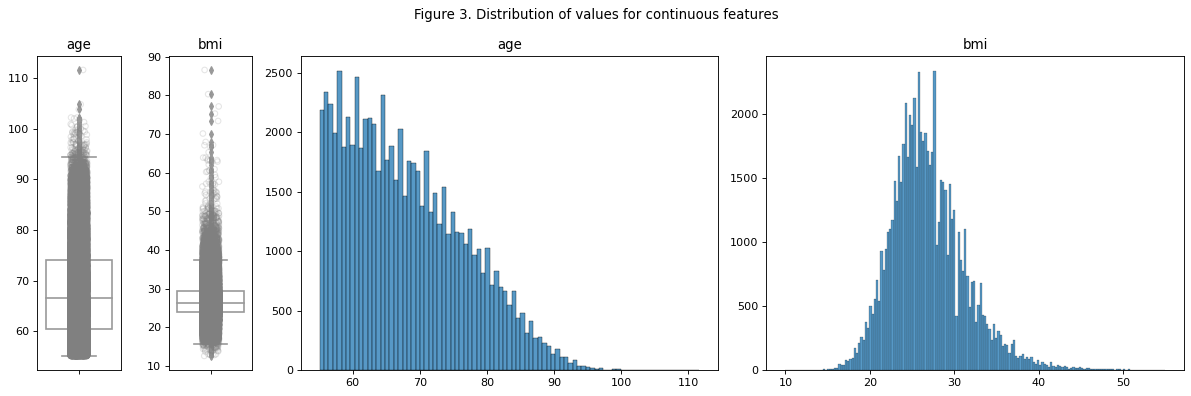

In [12]:
continuous = X_train[['age', 'bmi']]
fig, axs = plt.subplots(1, 4, width_ratios=[1, 1, 5, 5], figsize=(15, 5))

for ax, col in zip(axs.flat[:2], continuous.columns):
    sns.stripplot(y=continuous[col], facecolor="none", edgecolor='grey', linewidth=1, alpha=0.2, ax=ax)
    sns.boxplot(y=continuous[col], color='w', ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')

sns.histplot(continuous['age'], ax=axs[2], color='#1f77b4')
axs[2].set_title('age')
axs[2].set_xlabel('')
axs[2].set_ylabel('')

sns.histplot(continuous['bmi'], binrange=(10, 55), ax=axs[3], color='#1f77b4')
axs[3].set_title('bmi')
axs[3].set_xlabel('')
axs[3].set_ylabel('')

plt.suptitle('Figure 3. Distribution of values for continuous features')
plt.tight_layout()
plt.show()

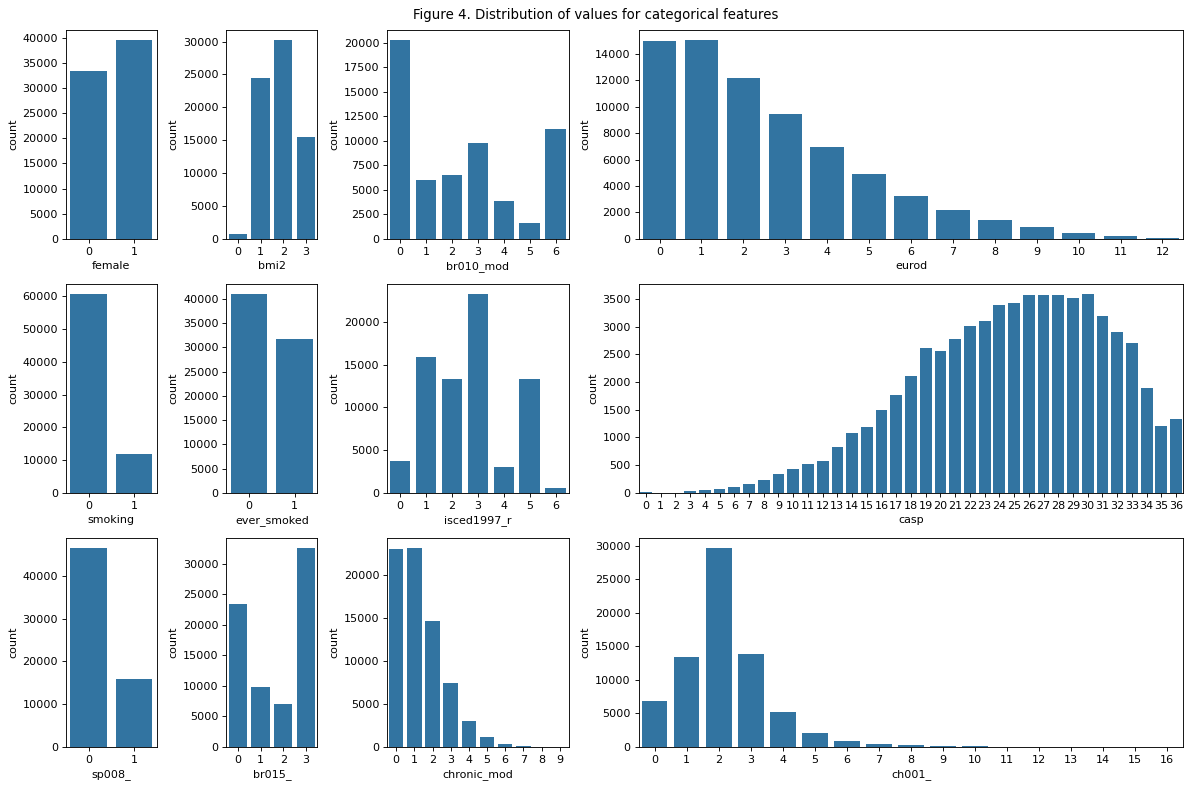

In [13]:
plot_order = ['female', 'bmi2', 'br010_mod', 'eurod',
              'smoking', 'ever_smoked', 'isced1997_r', 'casp',
              'sp008_', 'br015_', 'chronic_mod', 'ch001_']
categorical = X_train.drop(['age', 'bmi'], axis=1)[plot_order]

fig, axs = plt.subplots(3, 4, figsize=(15, 10), width_ratios=[1, 1, 2, 6])
for ax, col in zip(axs.flat, categorical.columns):
    sns.barplot(data=categorical[col].value_counts().reset_index(), x=col, y='count', ax=ax, color='#1f77b4')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

plt.suptitle('Figure 4. Distribution of values for categorical features')
plt.tight_layout()
plt.show()

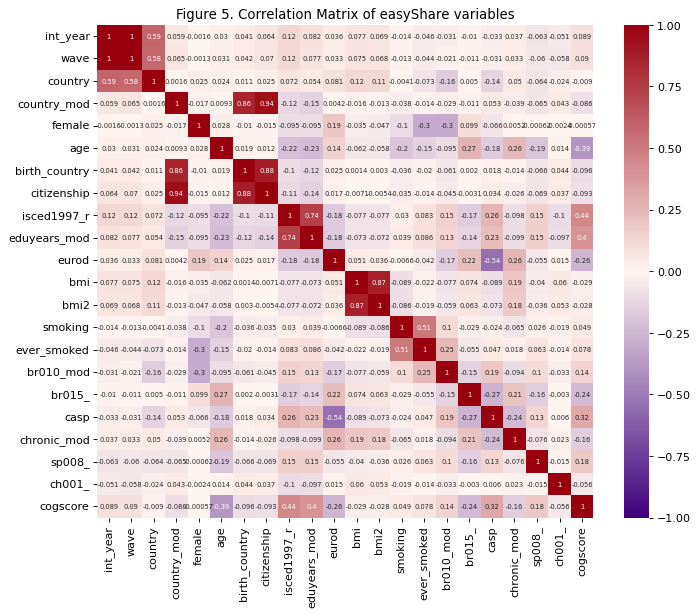

In [14]:
# Define the custom colour map
colors = ['#3f007d', '#fff5f0' ,'#99000d']  # Red, White, Purple
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Concatenate X_train and y_train to form a DataFrame
combined_df = X_train.join(y_train)

# Calculate the correlation matrix
correlation_matrix = combined_df.drop('mergeid', axis=1).corr()

# Plot the heatmap with the custom colour map
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, cmap=custom_cmap, vmin=-1, vmax=1, annot=True, annot_kws={'fontsize':6})

# Add title
plt.title('Figure 5. Correlation Matrix of easyShare variables')

# Show plot
plt.show()

In [15]:
print('Correlation of various features with `cogscore`')
print(X_train.join(y_train).drop('mergeid', axis=1).corr()['cogscore'].sort_values(key=lambda x: abs(x), ascending=False)[1:])

Correlation of various features with `cogscore`
isced1997_r      0.439632
eduyears_mod     0.398862
age             -0.388225
casp             0.315945
eurod           -0.260995
br015_          -0.236696
sp008_           0.183945
chronic_mod     -0.156872
br010_mod        0.139365
birth_country   -0.096423
citizenship     -0.092834
wave             0.090313
int_year         0.088798
country_mod     -0.086485
ever_smoked      0.078124
ch001_          -0.056191
smoking          0.048637
bmi             -0.029126
bmi2            -0.028376
country         -0.008997
female          -0.000566
Name: cogscore, dtype: float64


#### One hot encoding of `bmi2`

Even though fitting a linear model to the categorical feature `bmi2` as is would give us
an estimate of how `bmi2` influences `cogscore`, such a model would lack interpretability.
This is because a healthy BMI falls within the middle range of 18.5 to 24.9<sup>[5]</sup>.

By one-hot-encoding `bmi2` we can map both unhealthy (levels 1, 3, 4) and healthy (level 2) categories
to different changes in `cogscore`, allowing us to interpret how each category potentially influences
our explanatory variable.

In [16]:
# Drop NaN values from the 'bmi2' variable
X_train.dropna(subset=['bmi2'], inplace=True)

# Perform one-hot encoding on the 'bmi2' variable
# encoder = OneHotEncoder(drop='first', sparse=False)
encoder = OneHotEncoder(drop=None, sparse=False)
bmi2_encoded = encoder.fit_transform(X_train[['bmi2']])

# Convert the encoded array to a DataFrame
bmi2_encoded_df = pd.DataFrame(bmi2_encoded, columns=encoder.get_feature_names_out(['bmi2']))

# Concatenate the encoded DataFrame with the original DataFrame
X_train = pd.concat([X_train.reset_index().drop(columns=['bmi2']), bmi2_encoded_df], axis=1).set_index('index')


# Drop NaN values from the 'bmi2' variable
X_test.dropna(subset=['bmi2'], inplace=True)

# Perform one-hot encoding on the 'bmi2' variable
# encoder = OneHotEncoder(drop='first', sparse=False)
encoder = OneHotEncoder(drop=None, sparse=False)
bmi2_encoded = encoder.fit_transform(X_test[['bmi2']])

# Convert the encoded array to a DataFrame
bmi2_encoded_df = pd.DataFrame(bmi2_encoded, columns=encoder.get_feature_names_out(['bmi2']))

# Concatenate the encoded DataFrame with the original DataFrame
X_test = pd.concat([X_test.reset_index().drop(columns=['bmi2']), bmi2_encoded_df], axis=1).set_index('index')

#### New feature encoding from country data

In order to make country information more interpretable, we reduce the number of `country_mod`
categories by condensing them into two new features. These are `dev_coun`,
which indicates whether a country is highly developed (1) or developing (0), and
`coun_by_region`, where each country is assigned a non-overlapping region - `eastern_europe`,
`southern_europe`, `western_europe` and `northern_europe`.

In [17]:
# Define a function to map the development category
def map_development_category(code):
    # Assuming you have a list of developed country ISO codes
    developed_countries = [756, 276, 208, 724, 250, 246, 300, 191, 348, 372, 380, 
                           376, 440, 442, 428, 470, 528, 616, 620, 642, 752, 705, 703]
    
    # Check if the code is in the list of developed countries
    if pd.isnull(code):
        return code
    elif code in developed_countries:
        return 1  # Developed country
    else:
        return 0  # Developing country

# Apply the mapping function to create the new variable 'dev_coun'
X_train['dev_coun'] = X_train['country_mod'].apply(map_development_category)
X_test['dev_coun'] = X_test['country_mod'].apply(map_development_category)

In [18]:



# Define a function to categorise countries by region
def categorise_by_region(iso_code):
    eastern_europe = [203, 233, 191, 348, 428, 440, 616, 642, 705, 703,100]
    southern_europe = [196, 191, 300, 380, 470, 620, 724]
    western_europe = [40, 56, 756, 276, 250, 442, 528]
    northern_europe = [246, 208, 372, 752]
    # 376 Israel is not in EU
    if iso_code in eastern_europe:
        return 'east'
    elif iso_code in southern_europe:
        return 'south'
    elif iso_code in western_europe:
        return 'west'
    elif iso_code in northern_europe:
        return 'north'
    else:
        return 'israel'

# Apply the function to create the new variable 'coun_by_region'
X_train['coun_by_region'] = X_train['country_mod'].apply(categorise_by_region)
X_test['coun_by_region'] = X_test['country_mod'].apply(categorise_by_region)


encoder = OneHotEncoder(drop=None, sparse=False)
region_encoded = encoder.fit_transform(X_train[['coun_by_region']])

# Convert the encoded array to a DataFrame
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['coun_by_region']))

# Concatenate the encoded DataFrame with the original DataFrame
X_train = pd.concat([X_train.reset_index().drop(columns=['coun_by_region']), region_encoded_df], axis=1).set_index('index')

# encoder = OneHotEncoder(drop='first', sparse=False)
encoder = OneHotEncoder(drop=None, sparse=False)
region_encoded = encoder.fit_transform(X_test[['coun_by_region']])

# Convert the encoded array to a DataFrame
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['coun_by_region']))

# Concatenate the encoded DataFrame with the original DataFrame
X_test = pd.concat([X_test.reset_index().drop(columns=['coun_by_region']), region_encoded_df], axis=1).set_index('index')


#### Selection of features for model

As we are trying to model modifiable dementia risk factors, features describing interview
locational and temporal data (`mergeid`, `int_year`, `wave`, `country`, `country_mod`), as well
as those concerning personal data (`birth_country` and `citizenship`)
will be of no use to us as no relevant conclusions can be drawn from them. Therefore, we
drop these features from our data along with the condensed feature `country_mod`.

In [19]:
features_to_drop = ['mergeid', 'int_year', 'wave', 'country', 'country_mod', 'birth_country', 'citizenship']
X_train.drop(features_to_drop, axis=1, inplace=True)
X_test.drop(features_to_drop, axis=1, inplace=True)

print(f'Final number of observations in entire dataset: {X_train.shape[0] + X_test.shape[0]}')

Final number of observations in entire dataset: 94686


#### Examination of non-linear features

We next plot non-binary features against `cogscore` in Figure 6 to both identify any highly correlated features
and to look at non-linearity, which may require fitting a non-linear model for some features.
A trend-line with polynomial order 2 is fitted for each plot to allow examination of non-linear features.
We can see that for some features, such as `age`, `isced1997_r`, `br010_mod`, and `ch001_`,
the relationship with `cogscore` is likely non-linear.
As such, we will consider polynomial expansion for these features during model fitting.

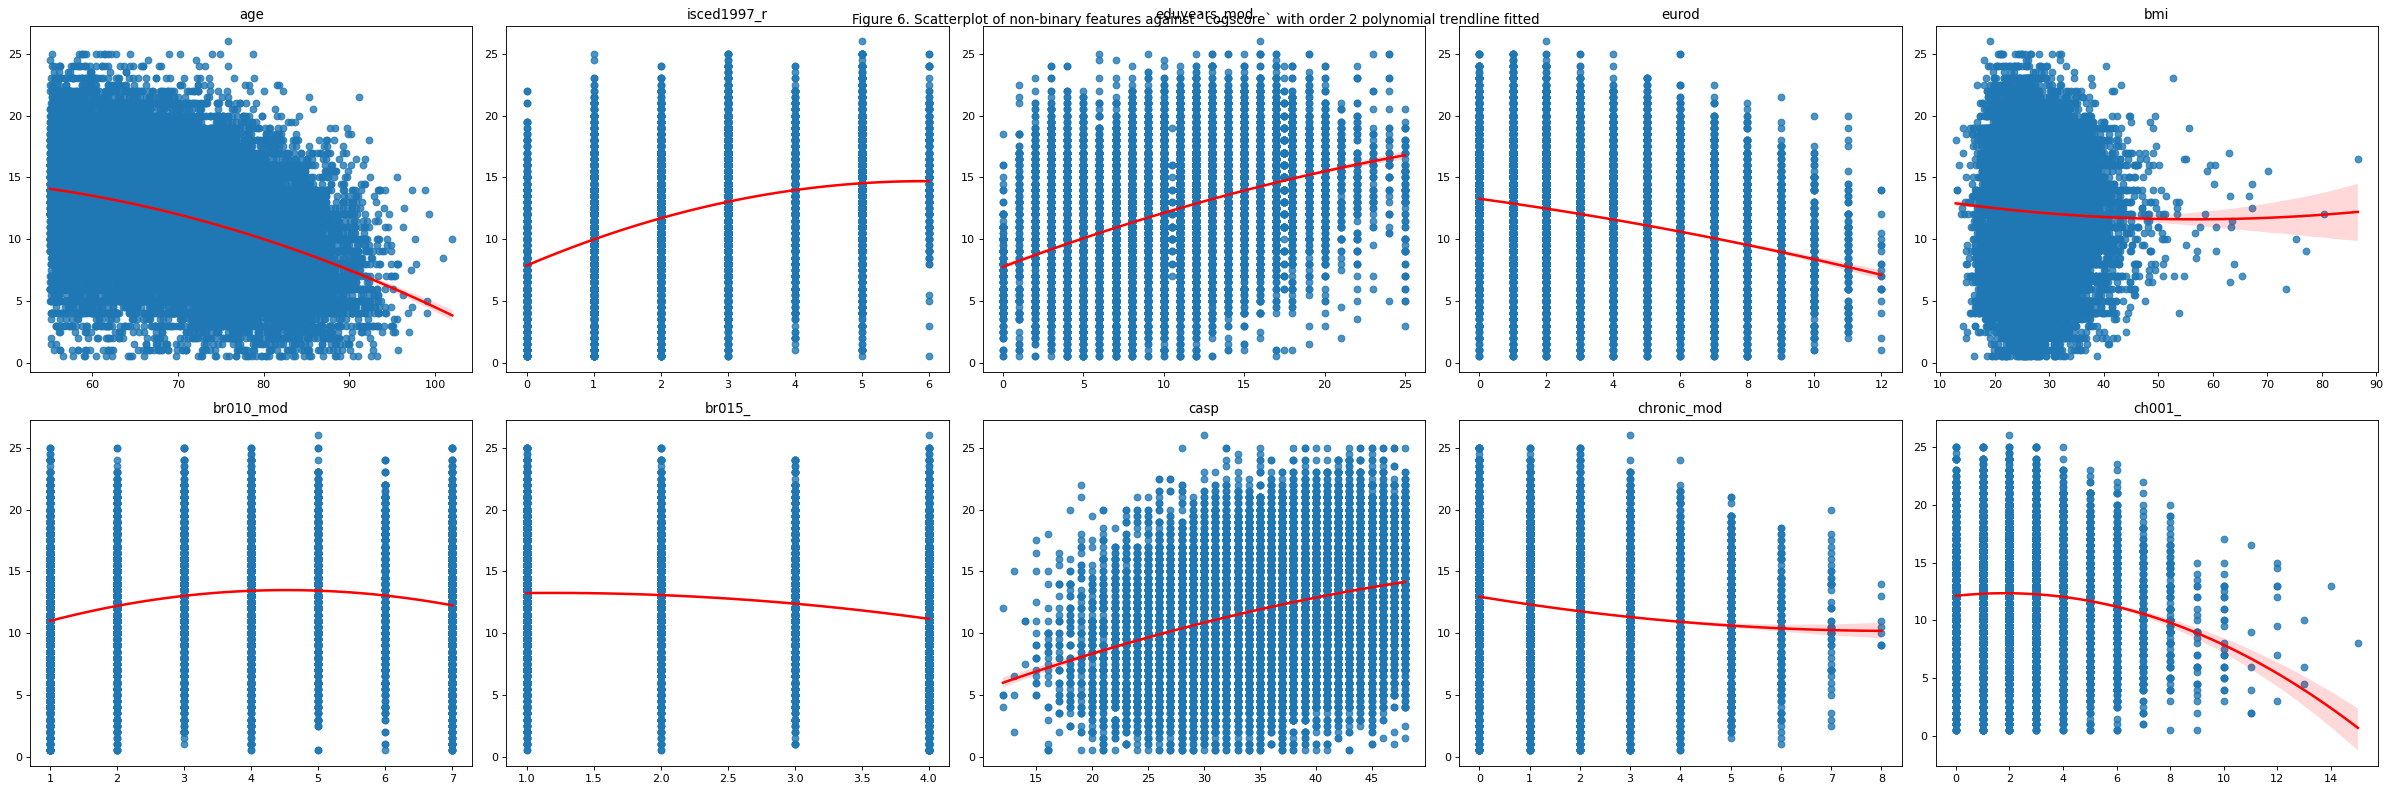

In [20]:
# Plot features against cogscore
fig, axs = plt.subplots(2, 5, figsize=(30, 10))

# Flatten the axis array
axs = axs.flatten()

X_train_plot = X_train.dropna()
y_train_plot = y_train.loc[X_train_plot.index]
columns_to_plot = ['age', 'isced1997_r', 'eduyears_mod', 'eurod', 'bmi', 'br010_mod', 'br015_', 'casp', 'chronic_mod', 'ch001_']

# Loop through each column (except 'female') to plot
for i, column in enumerate(X_train_plot[columns_to_plot]):
    # Create a scatter plot for the current variable
    sns.regplot(x=X_train_plot[column], y=y_train_plot, ax=axs[i], order=2, line_kws={"color": "red"})
    axs[i].set_title(f'{column}')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.suptitle('Figure 6. Scatterplot of non-binary features against `cogscore` with order 2 polynomial trendline fitted')
plt.show()

## Model Fitting and Interpretations

#### Baseline model

Having carried out data analysis and feature engineering on our dataset, we now
move onto model fitting and interpretation.
We first fit a baseline linear regression model that includes only the features most correlated with `cogscore`.
This model will serve as a comparison point with more complicated models that will
not only use different regression strategies, but also contain more features,
including those that were engineered by us (`dev_coun`, `coun_by_region`, and one-hot-encoded `bmi`).

The features chosen for the baseline model were found to be the most correlated with `cogscore`,
and are previously known from literature to be Dementia risk factors<sup>[2]</sup>.
These are `isced1997_r`, `age`, `casp`, `eurod`, and `br015_`.
We fit a simple linear regression and asses the model coefficients, MSE, R<sup>2</sup>,
and residuals. In this case an R<sup>2</sup> of 0.3106 indicates that there these features explain
only 31.06% of variation in `cogscore`. This is expected as we already know that
many lifestyle factors, including those uncaptured in the easySHARE data influence
cognitive function.

In [21]:
# Get feature names
feature_names = ['isced1997_r', 'age', 'casp', 'eurod', 'br015_']

# Drop NA values only from the specified columns
X_train_BM = X_train.dropna(subset=feature_names)
y_train_BM = y_train[X_train_BM.index]

baseline_model = Pipeline([
    # Column transformer to keep specific columns
    ('preprocessor', ColumnTransformer(
        [("included_cols", 'passthrough', feature_names)],
        remainder='drop'
    )),
    # Simple linear regression
    ('model', LinearRegression())
])

baseline_model.fit(X_train_BM, y_train_BM)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('included_cols',
                                                  'passthrough',
                                                  ['isced1997_r', 'age', 'casp',
                                                   'eurod', 'br015_'])])),
                ('model', LinearRegression())])

In [22]:
# Access the intercept
intercept = baseline_model.named_steps['model'].intercept_

# Access the coefficients
coefficients = baseline_model.named_steps['model'].coef_

# Display intercept and coefficients to 5 d.p
print("Intercept:", round(intercept, 5), '\n')
print("Coefficients:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {round(coef, 5)}")

Intercept: 16.16574 

Coefficients:
isced1997_r: 0.86743
age: -0.12501
casp: 0.08153
eurod: -0.14284
br015_: -0.16996


In [23]:
# Drop NA values only from the specified columns
X_test_BM = X_test.dropna(subset=feature_names)
y_test_BM = y_test[X_test_BM.index]
model_fit(baseline_model, X_test_BM, y_test_BM)

Mean Squared Error (MSE): 11.556737561696464
Root Mean Squared Error (RMSE): 3.3995201958065295
R-squared (R^2): 0.29707571708825775


#### Regularization (Ridge, Lasso, and ElasticNet)

We next consider fitting Ridge and Lasso regression, as well as their combination (Elastic Net)
to the full range of features in our dataset. These models both serve as a means to reduce overfitting
when modelling so many features, and also allow our model to generalize better unseen data.
Interestingly, both Ridge and Lasso produce the same MSE and R<sup>2</sup>
(MSE 10.85, R<sup>2</sup> 0.346 for both models vs MSE 11.56, R<sup>2</sup> 0.297 for the baseline).
These are significantly better than the baseline model, most likely due to the inclusion
of extra features. However, the very low alpha value obtained through cross-validation of the
Lasso and ElasticNet model, as well the many non-zero Lasso model coefficients indicate that very little
regularization is needed. We suspect this is due to the large number observations
in the easySHARE dataset, which help to reduce overfitting even when many features
are included in our model.

In addition, as seen from the model weight paths in Figure 7, the cross validation path of
Lasso also helps us identify the features that are most important for explaining variation in `cogscore` - they
are the last ones to be shrunk to zero. These are again `isced1997_r`, `age`, `casp`, `eurod`, and `br015_`.

In [24]:
# Drop rows with NaN values
X_train_cleaned = X_train.dropna()
# Align y_train with X_train_cleaned to remove corresponding rows
y_train_cleaned = y_train.loc[X_train_cleaned.index]

# Drop rows with NaN values
X_test_cleaned = X_test.dropna()
# Align y_train with X_train_cleaned to remove corresponding rows
y_test_cleaned = y_test.loc[X_test_cleaned.index]

In [25]:
alphas = np.logspace(-2, 3, num=200) # from 10^-2 to 10^3

# Create RidgeCV model with corrected input data
ridgecv_model = make_pipeline(
        StandardScaler(),
        RidgeCV(alphas=alphas, cv=5)
    )

# Fit the model
ridgecv_model.fit(X_train_cleaned, y_train_cleaned)

print("Ridge model\n-----------")

optimal_alpha = ridgecv_model[1].alpha_
print("Ridge optimal alpha:", optimal_alpha)

model_fit(ridgecv_model, X_test_cleaned, y_test_cleaned)

Ridge model
-----------
Ridge optimal alpha: 197.91668678535575
Mean Squared Error (MSE): 10.84788313464295
Root Mean Squared Error (RMSE): 3.2936124748735924
R-squared (R^2): 0.34648248573580764


In [26]:
alphas2 = np.logspace(-5, -2, num=200) # from 10^-2 to 10^3

ws = [] # Store coefficients
mses_train = [] # Store training mses

# Create LassoCV model with corrected input data
lassocv_model = make_pipeline(
        StandardScaler(),
        LassoCV(alphas=alphas2, cv=5)
    )

# Fit the model
lassocv_model.fit(X_train_cleaned, y_train_cleaned)

print("Lasso model\n-----------")

optimal_alpha = lassocv_model[1].alpha_
print("Lasso optimal alpha:", optimal_alpha)

ws.append(lassocv_model[-1].coef_) # Access the coefficients from the last element, Ridge model.
mses_train.append(mean_squared_error(y_train_cleaned, lassocv_model.predict(X_train_cleaned)))

model_fit(lassocv_model, X_test_cleaned, y_test_cleaned)

Lasso model
-----------
Lasso optimal alpha: 0.0029673024081888696
Mean Squared Error (MSE): 10.848677865375898
Root Mean Squared Error (RMSE): 3.2937331199379067
R-squared (R^2): 0.34643460815023097


In [27]:
print("Coefficients:\n")
for feature, coef in zip(lassocv_model.feature_names_in_, lassocv_model[1].coef_):
    print(f"{feature}: {round(coef, 5)}")

Coefficients:

female: 0.37915
age: -1.05787
isced1997_r: 0.94457
eduyears_mod: 0.3865
eurod: -0.41516
bmi: -0.0
smoking: -0.08401
ever_smoked: 0.10857
br010_mod: 0.11912
br015_: -0.23652
casp: 0.36008
chronic_mod: 0.03425
sp008_: 0.152
ch001_: -0.05961
bmi2_1.0: -0.04888
bmi2_2.0: 0.0
bmi2_3.0: -0.02977
bmi2_4.0: 0.00686
dev_coun: -0.15814
coun_by_region_east: -0.0
coun_by_region_israel: -0.10791
coun_by_region_north: 0.20386
coun_by_region_south: -0.18792
coun_by_region_west: 0.25275


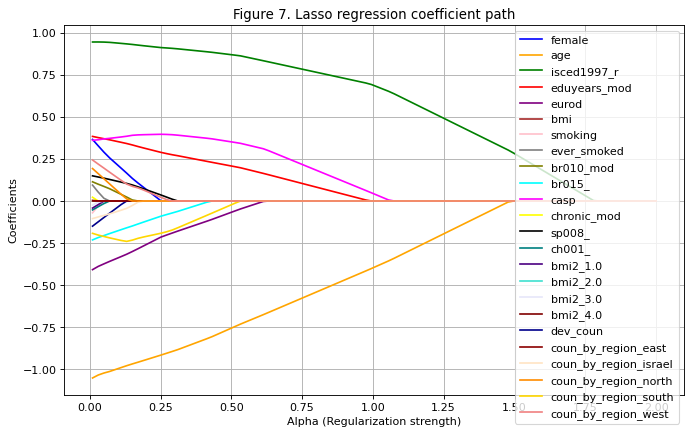

In [28]:
# Although Lasso can do feature selection, still drop irrelevant columns (identifier ID)
# because there is no meaningfful interpretation of their coefficients.
l2 = make_pipeline(
    StandardScaler(),
    Lasso()
).fit(X_train_cleaned, y_train_cleaned)

# new penalty term alpha2 for lasso solution path
alphas3 = np.linspace(0.01, 2, num=100) 
# Function to compute Lasso coefficients for different alpha values
def compute_coefficients_for_alphas(model, alphas):
    coefs = []
    for alpha in alphas:
        # Set new alpha value
        model.named_steps['lasso'].alpha = alpha
        # Refit the model with the same data
        model.fit(X_train_cleaned, y_train_cleaned)
        # Store coefficients
        coefs.append(model.named_steps['lasso'].coef_)
    return np.array(coefs)

# Compute coefficients for different alpha values
coefs = compute_coefficients_for_alphas(l2, alphas3)

plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 
          'olive', 'cyan', 'magenta', 'yellow', 'black', 'teal','indigo',
          'turquoise','Lavender','Maroon','darkblue', 'darkred', 'bisque', 'darkorange', 'gold', 'lightcoral']
for i in range(coefs.shape[1]):
    plt.plot(alphas3, coefs[:, i], label=X_train_cleaned.columns[i], color=colors[i])

plt.xlabel('Alpha (Regularization strength)')
plt.ylabel('Coefficients')
plt.title('Figure 7. Lasso regression coefficient path')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [29]:
l1_ratio = np.linspace(0.01, 1, 20)

# Create ElasticNetCV model with corrected input data
elasticnetcv_model = make_pipeline(
        StandardScaler(),
        ElasticNetCV(l1_ratio=l1_ratio, cv=5)
    )

# Fit the model
elasticnetcv_model.fit(X_train_cleaned, y_train_cleaned)

print("ElasticNet model\n----------------")

optimal_alpha = elasticnetcv_model[1].alpha_
print("Optimal alpha:", optimal_alpha)
optimal_l1_ratio = elasticnetcv_model[1].l1_ratio_
print("Optimal l1/l2 ratio:", optimal_l1_ratio)

model_fit(elasticnetcv_model, X_test_cleaned, y_test_cleaned)

ElasticNet model
----------------
Optimal alpha: 0.0034412305425651794
Optimal l1/l2 ratio: 0.8436842105263158
Mean Squared Error (MSE): 10.84868732318382
Root Mean Squared Error (RMSE): 3.2937345556653193
R-squared (R^2): 0.34643403837610576


#### Polynomial features

For polynomial regression, we consider the 4 features previously examined to be non-linear.
These are `isced1997_r`, `br010_mod`, `age`, and `casp`. Fitting a cross validation model
with these features expanded with degree 1-5 polynomials and the rest of the features left as is,
we obtain a model with an MSE of 10.76 and R<sup>2</sup> of 0.352 vs MSE 11.56 and R<sup>2</sup> 0.297 for the baseline.
This is even better than the result obtained by Ridge, Lasso, and ElasticNet, likely due
to the fact that the regularization strength in those models was very low and thus they were effectively
equivalent to a model with all features included, but without polynomial expansion, which contributed to the performance increase seen here.
The best polynomial degree chosen by GridSearchCV is 3. These results are a meaningful improvement over the baseline,
and thus we will be including these polynomial features in our final model.

In [30]:
# Define the included columns
included_columns = ['age','casp','isced1997_r','br010_mod']

# Drop NA values only from the specified columns
X_train_poly = X_train.dropna()
y_train_poly = y_train[X_train_poly.index]

# Drop NA values only from the specified columns
X_test_poly = X_test.dropna()
y_test_poly = y_test[X_test_poly.index]

In [31]:
# Polynomial features for interactions
pf_d_4powerful = PolynomialFeatures(include_bias=False)

# Overall ML pipeline
polyreg_pipe_4powerful = Pipeline([
    ("pre_processing", ColumnTransformer(
        [("poly", pf_d_4powerful, included_columns)],  # Apply polynomial features only to specific columns
        remainder='passthrough',
    )),
    ("model", LinearRegression(fit_intercept=True))
])

parameters = {
    'pre_processing__poly__degree': np.arange(1, 5, 1),
}

kf = KFold(n_splits=5, shuffle=True)

grid_search_4powerful = GridSearchCV(polyreg_pipe_4powerful, parameters, cv=kf, scoring='neg_mean_squared_error', return_train_score=True).fit(X_train_poly, y_train_poly)

print("PolynomialFeatures model\n------------------------")
print("Best polynomial order: ", grid_search_4powerful.best_params_['pre_processing__poly__degree'])
model_fit(grid_search_4powerful.best_estimator_, X_test_poly, y_test_poly)

PolynomialFeatures model
------------------------
Best polynomial order:  3
Mean Squared Error (MSE): 10.755233664004521
Root Mean Squared Error (RMSE): 3.279517291310494
R-squared (R^2): 0.352064040311756


#### Final model

For our final model we carry out a combination of the previously aforementioned 3rd order polynomial
expansion on the features `isced1997_r`, `br010_mod`, `age`, and `casp`, as well as fitting
a Lasso model. Lasso is chosen here as it was the optimal solution from cross validating
our ElasticNet model (an `l1_ratio` of 1.0 corresponds to a Lasso model), and it slightly reduces the
number of features in our model by shrinking some of their coefficients to zero.
For polynomial feature expansion we select the previously cross validated degree of 3,
and for Lasso regularization strength we perform a grid search of 50 alpha values from 10<sup>-5</sup> to 10<sup>-2</sup>.

The final model has an MSE of 10.77 and R<sup>2</sup> of 0.351, explaining 35.1% of the variation in `cogscore`.
Because we standardize our features before fitting our model, in order to interpret the model coefficients properly
we have to first unstandardize them by dividing each weight by the associated stdev for that feature.

With the caveat that `cogscore` ranges between 0 and 26, and is only an indirect measure cognitive ability,
we can now interpret our model coefficients. Among the highest of these is for `isced1997_r`, indicating
that as people progress through the levels of education, for each level we see an on average linear increase
of 1.0553 in `cogscore`. This is not including the non-linear component and interaction terms from
polynomial features, which also mostly show a positive trend.

Examining some of the binary variables we can see that, interestingly,
females show an on average 0.76754 higher `cogscore` than males, and people who give help to others
outside the household have a `cogscore` 0.32048 higher than those that don't.

We find that only the underweight `bmi2` category corresponds to a significantly (-0.43869) lower value
of `cogscore`, although this may in fact be due to the limited number of observations in
this category and thus the high error of this weight estimate.

>TODO: expand on more coefficients

This interpretation explains how different factors affect cognitive scores in relation to dementia risk. 

The first coefficient is the intercept (12.2), representing the baseline predicted cognitive score when all other predictors are zero. The intercept is a critical parameter as it defines the cognitive well-being of an individual with no information about age, quality of life, education, or drinking behavior, and belonging to a reference region. A clear understanding of the intercept is essential to assessing the potential deviation from a neutral cognitive state.

The second coefficient is age (0.03097), and a one-unit increase in age is associated with an increase by 0.03097 in cognitive scores. However, it is important to note that higher cognitive scores do not necessarily translate to a lower risk of dementia.

Quality of life is the third coefficient (casp: 0.0873), and a one-unit improvement in quality of life corresponds to a meaningful increase in cognitive scores. This positive relationship implies that individuals with better quality of life may have a lower risk of dementia.

The fourth coefficient is education level (isced1997_r: 1.0553), and it has a significant positive coefficient, which indicates that higher levels of education are associated with a significantly higher increase in predicted cognitive scores. Higher cognitive scores, in turn, may indicate a lower risk of dementia.

The fifth coefficient is drinking behavior (br010_mod: 0.13385), and it has a moderate positive coefficient that indicates a moderate increase in cognitive scores with a one-unit change in drinking behavior. However, it is crucial to interpret this in the context of known relationships between alcohol consumption and dementia risk.

The sixth and seventh coefficients are quadratic and cubic terms for age, respectively (age^2: -0.00021, age^3: -1e-05). The negative coefficient of age squared introduces a concave pattern, suggesting a decreasing rate of improvement in cognitive scores with age. This nonlinear relationship might imply that the risk of dementia may increase at a decreasing rate as individuals age. The cubic term adds further complexity, potentially indicating non-monotonic patterns in dementia risk as individuals age.

The eighth and ninth coefficients are interaction effects between age and quality of life and education level, respectively (age casp: 0.00026, age isced1997_r: 0.00016). These interactions suggest that maintaining a higher quality of life and education level can be beneficial in mitigating dementia risk as individuals age.

The final coefficients refer to regional influences on cognitive scores (coun_by_region_israel: -0.76619, coun_by_region_north: 0.42928, coun_by_region_south: -0.45371, coun_by_region_west: 0.3693). The negative coefficient for Israel suggests a substantial decrease in the predicted cognitive score compared to the reference region, which implies that individuals in Israel might face an elevated risk of dementia. The high positive coefficient for the northern region suggests a significant increase, potentially associated with a lower risk of dementia. The very negative coefficient for the southern region implies a substantial decrease, indicating a potential higher risk of dementia. Finally, the positive coefficient for the western region indicates a noticeable increase, potentially associated with a lower risk of dementia.

In [38]:
# Overall ML pipeline
final_model = Pipeline([
    ("pre_processing", ColumnTransformer(
        [("poly", PolynomialFeatures(include_bias=False, degree=3), included_columns)],  # Apply polynomial features only to specific columns
        remainder='passthrough',
    )),
    ("scaler", StandardScaler()),
    ("model", Lasso(fit_intercept=True))
])

parameters = {
    'model__alpha': np.logspace(-5, -2, 50)
}

kf = KFold(n_splits=5, shuffle=True)

final_model_cv = GridSearchCV(final_model, parameters, cv=kf, scoring='neg_mean_squared_error', return_train_score=True).fit(X_train_poly, y_train_poly)

Final model
-----------
Best alpha:  0.0003906939937054617
Mean Squared Error (MSE): 10.766205423663557
Root Mean Squared Error (RMSE): 3.2811896354315695
R-squared (R^2): 0.35140306000707533


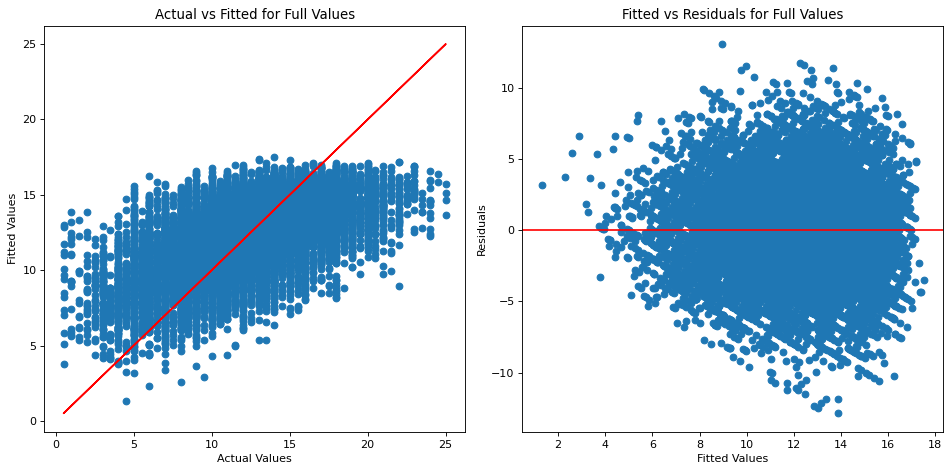

In [54]:
print("Final model\n-----------")
print("Best alpha: ", final_model_cv.best_params_['model__alpha'])
model_fit(final_model_cv.best_estimator_, X_test_poly, y_test_poly, plot=True)

In [53]:
print("Intercept:", round(final_model_cv.best_estimator_[2].intercept_, 5), '\n')
print("Coefficients:\n-------------")
for feature, coef, std in zip(final_model_cv.best_estimator_[0].get_feature_names_out(), final_model_cv.best_estimator_[2].coef_, final_model_cv.best_estimator_[1].scale_):
    print(f"{feature.split('__')[1]}: {round(coef/std, 5)}")

Intercept: 12.21191 

Coefficients:
-------------
age: 0.03097
casp: 0.0873
isced1997_r: 1.0553
br010_mod: 0.13385
age^2: -0.00021
age casp: 0.00026
age isced1997_r: 0.00016
age br010_mod: 0.00217
casp^2: 0.0
casp isced1997_r: 0.00358
casp br010_mod: -0.0011
isced1997_r^2: 0.00107
isced1997_r br010_mod: -0.01294
br010_mod^2: -0.01456
age^3: -1e-05
age^2 casp: -1e-05
age^2 isced1997_r: -0.0001
age^2 br010_mod: 4e-05
age casp^2: 1e-05
age casp isced1997_r: 0.0002
age casp br010_mod: 2e-05
age isced1997_r^2: 0.00041
age isced1997_r br010_mod: -0.00029
age br010_mod^2: -0.00058
casp^3: -2e-05
casp^2 isced1997_r: -8e-05
casp^2 br010_mod: -0.0
casp isced1997_r^2: -0.00296
casp isced1997_r br010_mod: -0.0
casp br010_mod^2: -2e-05
isced1997_r^3: 0.0
isced1997_r^2 br010_mod: 0.0
isced1997_r br010_mod^2: 0.00465
br010_mod^3: 0.0
female: 0.76754
eduyears_mod: 0.09463
eurod: -0.16842
bmi: -0.00438
smoking: -0.22283
ever_smoked: 0.20277
br015_: -0.16672
chronic_mod: 0.02535
sp008_: 0.32048
ch001_: 

## Discussion and conclusions

>TODO: compare with literature, conclude which modifiable features

The goal of this study was to make use of the vast set of publically available data
from the easySHARE dataset in order to identify key modifiable risk factors for dementia.
To this end, we employed a statistical modelling approach to identify a link between
various features described in the easySHARE dataset and a composite cognitive function score.
It is important to note that the cognitive score used here is only a proxy for dementia risk.
Dementia is known to lead to impaired cognitive function<sup>[6]</sup>, and thus a lower
cognitive score here correlates with an increased risk of dementia.

Because the easySHARE data was collected exclusively on people aged over 50 in
Europe, conclusions drawn here may not necessarily apply to the wider global population,
nor necessarily apply to people that are younger. Additionally, because the version of easySHARE we
use here only contains a single observation per person, we are only capturing a
static image of the population. The full SHARE dataset instead interviews the same people
throughout multiple years, capturing how both cognitive function and the factors that
influence change through time.

Our models identify and expand on several previously known factors...

The primary modifiable factors identified here are...


## References

1. The top 10 causes of death” World Health Organization, accessed February 26, 2024,
https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death

2. Livingston et al (2020). Dementia prevention, intervention, and care: 2020 report of the
Lancet Commission. Lancet. 396(10248):413-446.

3. TBörsch-Supan, A. & S. Gruber (2022): easySHARE. Release version: 8.0.0. SHARE-ERIC. Dataset. doi: 10.6103/SHARE.easy.800

4. Borrat-Besson, C., Ryser, V.-A., & Gonçalves, J. (2015). An evaluation of the CASP-12 scale used in the Survey of Ageing and Retirement in Europe (SHARE) to measure Quality of Life among people aged 50+. FORS Working Paper Series, paper 2015-4. Lausanne: FORS.

5. Nhs.uk, (2022) 'What is the body mass index (BMI)?', [online] Available from: https://www.nhs.uk/common-health-questions/lifestyle/what-is-the-body-mass-index-bmi/ (Accessed 09 March 2024).

6. Nhs.uk, (2023) 'Symptoms of dementia', [online] Available from: https://www.nhs.uk/conditions/dementia/symptoms-and-diagnosis/symptoms/ (Accessed 10 March 2024).